# ロジスティック回帰

## 【事前準備】

In [1]:
# scikit-learnの「set_config(display="diagram")」を使用するため、scikitlearnを最新verに更新
# !pip install scikit-learn==0.23.2 --target drive/My\ Drive/MyModule
# !pip install scikit-learn==0.23.2
# !pip list
## Google Drive上にインストールしたモジュールのインポート##
import sys
sys.path.append('/content/drive/My Drive/MyModule')

In [2]:
## モジュールのインポート ##
# 一般
import random
import math
# データ分析
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
%matplotlib inline
matplotlib.style.use('ggplot')
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
# その他
from google.colab import drive #GoogleDriveモジュール
# drive.mount('/content/drive') #GoogleDriveのマウント

## 【実装】

### ●ScratchLogisticRegressionクラスの定義

In [3]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装
    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue
    threshold : float
      推定値の確率の閾値 (0 < threshold < 1)
    ramda : float
      正則化項の係数（ramda ≧ 0）
    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録
    self.label_list :  次の形のndarray, shape (2,)
      fitメソッドにて学習した2値の正解ラベル
    """
    def __init__(self, num_iter, lr, no_bias, verbose=False, threshold=0.5, ramda=0.5):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.bias = no_bias
        self.verbose = verbose
        self.threshold = threshold
        self.ramda = ramda
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        # パラメータを空配列で初期化
        self.coef_ = np.array([])   # 傾き（各特徴量に対する重み）
        self.intercept_ = 0   # 切片
        self.coef_log = np.array([])   #パラメータ更新ログ
        self.label =  np.zeros(2)  #2値の正解ラベル
        # デバッグ情報出力
        if self.verbose:
            print("        イテレーション数:{}, 学習率:{}".format(self.iter, self.lr))

    def fit(self, X, y, X_val=None, y_val=None):
        """
        線形回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # 切片への乗算用の列（全て1）を、Xに追加
        X_add1 = self._add_ones_vector(X)

        # 正解ラベルyをインスタンス変数に保持（正解ラベルが2値以外の場合は強制終了）
        self.label = np.unique(y)
        if (len(self.label) != 2):
            print("Warning: 正解ラベルが2値ではありません。学習を中断します。")
            return
        # 正解ラベルyの2値を0と1に変換
        y_transformed = np.where(y == np.max(self.label), 1, 0)

        
        if ((X_val is not None) and (y_val is not None)):
            # 検証データが与えられた場合は検証データも上記の変換処理を実施
            X_val_add1 = self._add_ones_vector(X_val)  # 切片への乗算用の列（全て1）を、Xに追加
            y_val_transformed = np.where(y_val == np.max(self.label), 1, 0)  # 正解ラベルyの2値を0と1に変換
        else:
            # 検証データがない場合はNoneをセット
            X_val_add1 = None
            y_val_transformed = None

        # 特徴量の数（=Xの列数）に合わせてパラメータを初期化
        self.coef_ = np.zeros(X_add1.shape[1])

        # パラメータ更新ログを初期化 (各列が特徴量ごとのパラメータとなるようにreshape)
        self.coef_log = self.coef_.reshape(1, self.coef_.shape[0]).copy()

        # デバッグ情報出力
        if self.verbose:
            print("        パラメータ初期値:{}".format(self.coef_))
            print("        パラメータ更新ログ:{}".format(self.coef_log))

        # 最急降下法により最適なパラメータ（self.coef_）を決定
        self._gradient_descent(X_add1, y_transformed, X_val_add1, y_val_transformed)

        # 切片に値をセット(self.coef_の先頭要素が切片)
        self.intercept_ = self.coef_[0]

        # （検証用データが与えられた場合のみ）学習曲線をプロット
        if ((X_val is not None) and (y_val is not None)):
            # plot_learning_curve(X_val, y_val)
            pass

        return

    def predict(self, X):
        """
        ロジスティック回帰を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            特徴量データ
        Returns
        -------
        y_pred_proba : 次の形のndarray, shape (n_samples, 1)
            特徴量データに対する推定結果
        """
        # 切片への乗算用の列（全て1）を、Xに追加
        X_add1 = self._add_ones_vector(X)

        # データセットXから目的変数yの確率（n_sample x 1のベクトル）を算出
        y_pred_proba = self._logistic_hypothesis(X_add1)
        # 確率が閾値以上の場合は正解ラベルの大きい方の値を、閾値未満の場合は小さい方の値を推定値として出力
        ret_y_pred = np.where(y_pred_proba >= self.threshold, np.max(self.label), np.min(self.label))

        ret_y_pred = np.ravel(ret_y_pred)

        return ret_y_pred

    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
        y_pred_proba : 次の形のndarray, shape (n_samples, 1)
            特徴量データに対する目的変数の確率の推定結果
        """
        # 切片への乗算用の列（全て1）を、Xに追加
        X_add1 = self._add_ones_vector(X)

        # データセットXから目的変数yの確率（n_sample x 1のベクトル）を算出
        y_pred_proba_1 = self._logistic_hypothesis(X_add1)  # 1である確率
        y_pred_proba_0 = 1 - y_pred_proba_1    # 0である確率

        ret_y_pred_proba = np.concatenate([y_pred_proba_0, y_pred_proba_1], axis=1)

        return  ret_y_pred_proba

    def _logistic_hypothesis(self, X):
        """
        ロジスティックの仮定関数を計算する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            特徴量
        Returns
        -------
        ret_y_pred : 次の形のndarray, shape (n_samples, 1)
            仮定関数による推定結果
        """
        
        # 特徴量の数: n_features (X.shape[1])
        # 線形重回帰の式: z = w0X0 + w1X1 + … + wnXn = x・w (x: n_samples x n_featuresの行列,  w(=coef_): n_features x 1のベクトル)
        z_pred = X @ self.coef_.reshape(X.shape[1], 1)

        #出力されたzを、シグモイド関数に入力
        ret_y_pred = 1 / (1 + math.e**(-z_pred))

        return ret_y_pred

    def _gradient_descent(self, X_add1, y, X_val_add1=None, y_val=None):
        """
        最急降下法によりパラメータを計算する
        Parameters
        ----------
        X_add1 : 次の形のndarray, shape (n_samples + 1, n_features)
            訓練データの特徴量(に、値が全て1の列を先頭に追加した行列)
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val_add1 : 次の形のndarray, shape (n_samples + 1, n_features)
            検証データの特徴量(に、値が全て1の列を先頭に追加した行列)
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        error : ?
        Returns
        -------
        None
        """
        n_samples = X_add1.shape[0]    # 全データ数
        n_features = X_add1.shape[1]    # 特徴量の数
        update_counter = 0  # パラメータの更新回数
        
        # デバッグ情報出力
        if self.verbose:
            print("        全データ数:{}".format(n_samples))

        #イテレーション数だけパラメータを更新する
        for k in range(self.iter):
            # デバッグ情報出力
            if self.verbose:
                print("            イテレーション:{}回目".format(k))

            # 特徴量データXから目的変数yの確率（n_sample x 1のベクトル）を推定
            y_pred_proba = self._logistic_hypothesis(X_add1)   #学習データ
            if (X_val_add1 is not None):
                y_val_pred_proba = self._logistic_hypothesis(X_val_add1)   #検証データ
            
            # 各特徴量のパラメータを順番に更新
            for j in range(n_features):
                # 勾配の値を初期化
                temp_gradient = 0
                # 現在のパラメータ値における勾配（Σ(h(xi)-yi)Xij）を計算
                if (j == 0):
                    # [j==0]勾配: "1/mΣ(h(xi)-yi)Xij"
                    for i in range(n_samples):
                        temp_gradient += (1/n_samples) * (y_pred_proba[i] - y[i]) * X_add1[i, j]
                else:
                    # [j>0] 勾配: "1/m(Σ(h(xi)-yi)Xij + λ*wj"
                    for i in range(n_samples):
                        temp_gradient += (1/n_samples) * (y_pred_proba[i] - y[i]) * X_add1[i, j] + self.ramda * self.coef_[j]
                        
                # パラメータを更新
                self.coef_[j] = self.coef_[j] - self.lr * temp_gradient

                # デバッグ情報出力
                if self.verbose:
                    if (j == 0):
                        print("                切片:")
                    else:
                        print("                {}番目の特徴量:".format(j))
                    print("                    勾配:{}、パラメータ:{}".format(temp_gradient, self.coef_[j]))

            update_counter += 1

            # 損失関数を計算して内部変数に記録(検証データがある場合は検証データも)
            self.loss[k] = self._calcurate_loss(y, y_pred_proba)  # 学習データ  #検証データに対する損失
            if (y_val is not None):
                self.val_loss[k] = self._calcurate_loss(y_val, y_val_pred_proba)  #検証データに対する損失
            # 現在のパラメータを更新ログに記録
            self.coef_log = np.append(self.coef_log, self.coef_.reshape(1, self.coef_.shape[0]), axis=0) 

            # デバッグ情報出力
            if self.verbose:
                print("            パラメータの更新回数:{}".format(update_counter))
        return

    def _add_ones_vector(self, X):
        """
        切片(=self.coef_[0])への乗算用の列（全て1）を、Xに追加する関数
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        Returns
        -------
        ret_X : 次の形のndarray, shape (n_samples, n_features + 1)
            訓練データに、値が全て1の列を追加したもの
        """
        ones_ndarray = np.ones((X.shape[0], 1))
        ret_X = np.concatenate([ones_ndarray, X], axis=1)
        return ret_X

    def _calcurate_loss(self, y_true, y_pred_proba):
        """
        損失関数の計算
        Parameters
        ----------
        y_pred_proba : 次の形のndarray, shape (n_samples,)
          目的変数の確率の推定値
        y_true : 次の形のndarray, shape (n_samples,)
          目的変数の正解値
        Returns
        ----------
        loss : numpy.float
          ロジスティック回帰の損失関数(Log Loss)
        """
        n_sample = len(y_pred_proba)

        # yの推定値と正解値の配列に、明示的に列情報を付与
        y_pred_proba = y_pred_proba.reshape(y_pred_proba.shape[0], 1)
        y_true = y_true.reshape(y_true.shape[0], 1)

        # loss = (1 / (2 * n_sample)) * (((y_pred - y_true)**2).sum())
        loss = (1 / n_sample) * (- y_true * np.log(y_pred_proba) - (1 - y_true) * np.log(1 - y_pred_proba)).sum()

        # デバッグ用情報出力
        if self.verbose:
            print("                loss:{}".format(loss))
        return loss

    def plot_learning_curve(self):
        """
        学習曲線をプロットする関数
        Parameters
        ----------
        None
        Returns
        -------
        None
        """
        # 学習データと検証データのそれぞれの損失関数の値をグラフに描画
        fig, ax = plt.subplots(figsize=(15, 10), dpi=50)
        ax.set_title("Learning Curve")
        ax.set_xlabel("Iteration Number")
        ax.set_ylabel("Loss")
        ax.plot(self.loss, color = "blue", label="train")
        ax.plot(self.val_loss, color = "red", label="validation")
        ax.legend(loc='best') # 凡例を最適位置に表示
        plt.show()

        return

### ●データセットの準備（アヤメのデータセット）

In [4]:
## アヤメのデータセット ##
np.set_printoptions(threshold=100)   #配列の表示数上限の設定

from sklearn.datasets import load_iris
iris = load_iris()
print("iris.target_names: {}".format(iris.target_names))

df_X = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df_y = pd.DataFrame(data=iris.target, columns=["species"])
df_iris_org = pd.concat([df_X, df_y], axis=1)

pd.set_option('display.max_rows', 10)    #DataFrameの行の表示数上限の設定
pd.set_option('display.max_columns', 5)   #DataFrameの列の表示数上限の設定

print("\n")
print("df_iris_org:")
display(df_iris_org)


#目的変数（正解ラベル）をvirgicolorとvirginicaのみに削減する。（Setosaのデータ行を削除する）
df_1 = df_iris_org[df_iris_org.loc[:, "species"]==1]
df_2 = df_iris_org[df_iris_org.loc[:, "species"]==2]
df_iris = pd.concat([df_1, df_2], axis=0)
# df_iris["sepal length (cm)"] = (df_iris["sepal length (cm)"]*100000 + 100000)
print("\n")
print("df_iris:")
display(df_iris)

X = np.array(df_iris.iloc[:, :-1])
y = np.array(df_iris.iloc[:, -1])

#データセットを学習用と検証用に分割
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, train_size = 0.75, random_state=0)

iris.target_names: ['setosa' 'versicolor' 'virginica']


df_iris_org:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2




df_iris:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
50,7.0,3.2,4.7,1.4,1
51,6.4,3.2,4.5,1.5,1
52,6.9,3.1,4.9,1.5,1
53,5.5,2.3,4.0,1.3,1
54,6.5,2.8,4.6,1.5,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


### ●推定器の評価指標を記録するスコアボードのクラス

In [5]:
## 推定器の指標値を記録するスコアボードのクラス ##
class ScoreBoard():
    def __init__(self, name1=None, name2=None):
        self.df_score = pd.DataFrame([])   #各指標値を記録するDataFrame
        if (name1 is None):   name1 = ""
        if (name2 is None):   name2 = ""
        self.name1 = name1
        self.name2 = name2
        print("{}スコアボード{}が生成されました。".format(self.name1, self.name2))
    def calcurate_scores(self, arg_y_true, arg_y_predict, arg_y_predict_proba, arg_columns):
        # Accuracy（正解率）
        accuracy = accuracy_score(arg_y_true, arg_y_predict)

        #Precision（適合率）
        precision = precision_score(arg_y_true, arg_y_predict)

        #Recall（再現率）
        recall = recall_score(arg_y_true, arg_y_predict)

        #F値
        f1 = f1_score(arg_y_true, arg_y_predict)

        #AUC
        roc_auc = roc_auc_score(arg_y_true, arg_y_predict_proba)

        #Confusion matrix（混同行列）
        print("\n")
        print("###Confusion matrix（混同行列）###")
        print(confusion_matrix(arg_y_true, arg_y_predict))

        #指標値の比較用テーブルに登録
        # if(self.df_score.empty):
        #     self.df_score = pd.DataFrame([accuracy, precision, recall, f1, roc_auc], index=["Accuacy", "Precision", "Recall", "F1", "ROC_AUC"], columns=arg_columns)
        # else:
        df_score_temp = pd.DataFrame([accuracy, precision, recall, f1, roc_auc], index=["Accuacy", "Precision", "Recall", "F1", "ROC_AUC"], columns=arg_columns)
        self.df_score = pd.concat([self.df_score, df_score_temp], axis=1)
        print("\n")
        print("{}スコアボード{}:".format(self.name1, self.name2))
        display(self.df_score)

        # #ROC曲線、AUC
        # #y_testの値を2→1, 1→0に変換
        # y_test1_dummy = np.where(y_test1==1, 0, 1)
        # fpr, tpr, thresholds = metrics.roc_curve(y_test1_dummy, y_predict_proba[:, -1]) # FPR（偽陽性率）、TPR（真陽性率）、閾値を算出
        # auc = metrics.auc(fpr, tpr)  # AUCを算出
        # plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
        # plt.legend()
        # plt.title('ROC curve')
        # plt.xlabel('False Positive Rate')
        # plt.ylabel('True Positive Rate')
        # plt.grid(True)

        # 決定領域を描画
        # decision_region(X_train_transformed, y_train, model=clf, step=0.01, title='decision region', xlabel=df3.columns[0], ylabel=df3.columns[1], target_names=df3.iloc[:, -1].unique())
        
        return

# スコアボードをインスタンス化
score_board1 = ScoreBoard(name2 = "1")
score_board2 = ScoreBoard(name2 = "2")

スコアボード1が生成されました。
スコアボード2が生成されました。


## 【問題1】仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。


ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものです。シグモイド関数は以下の式で表されます。


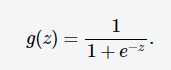


線形回帰の仮定関数は次の式でした。


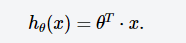



まとめて書くと、ロジスティック回帰の仮定関数は次のようになります。



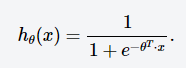


$x$ : 特徴量ベクトル


$\theta$ : パラメータ（重み）ベクトル

### 【問題1 解答】
ロジスティック回帰の仮定関数を、「_logistic_hypothesisメソッド」としてScratchLogisticRegressionクラス内に実装した。

## 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。

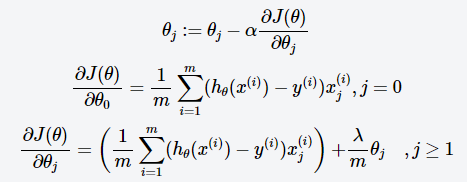

$\alpha$ : 学習率


$i$ : サンプルのインデックス


$j$ : 特徴量のインデックス


$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数


$x$ : 特徴量ベクトル


$\theta$ : パラメータ（重み）ベクトル


$x^{(i)}$ : i番目のサンプルの特徴量ベクトル


$y^{(i)}$ : i番目のサンプルの正解ラベル


$\theta_j$ : j番目のパラメータ（重み）


$λ$ : 正則化パラメータ


以上の式には正則化項が含まれます。正則化項は過学習を防ぐ目的で用いられます。切片である$\theta_0$が正則化項に含まれていないのは、切片を除いた、特徴量に対する係数を同じ視点で議論することができるようにするためです。



### 【問題2 解答】
_gradient_descentメソッドをScratchLogisticRegressionクラス内に実装し、fitメソッドから呼び出すように実装した。

## 【問題3】推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。


仮定関数 $h_\theta(x)$ の出力がpredict_probaの戻り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの戻り値となります。

### 【問題3 解答】
predictメソッドとpredict_probaメソッドをScratchLogisticRegressionクラス内に実装した。

## 【問題4】目的関数
以下の数式で表されるロジスティック回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。


なお、この数式には正則化項が含まれています。


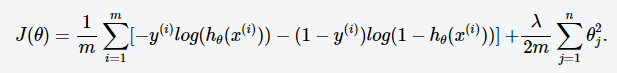


$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数


$x$ : 特徴量ベクトル


$\theta$ : パラメータ（重み）ベクトル


$x^{(i)}$ : i番目のサンプルの特徴量ベクトル


$y^{(i)}$ : i番目のサンプルの正解ラベル


$\theta_j$ : j番目のパラメータ（重み）


$n$ : 特徴量の数


$λ$ : 正則化パラメータ

### 【問題4 解答】
損失関数の計算処理(_calcurate_lossメソッド)、およびイテレーション時にself.lossおよびself.val_lossに損失を記録する処理をScratchLogisticRegressionクラス内に実装した。

## 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

#### ●【動作確認】ScratchLogisticRegressionクラスを用いたロジスティック回帰（イテレーション:10）

In [6]:
# 標準化処理とロジスティック回帰をパイプラインに組み込み
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),      #変換器
    ("classifier", ScratchLogisticRegression(num_iter=10, lr=0.2, no_bias=0, verbose=True, threshold=0.5, ramda=0)) #推定器
])

# データセット1に対して学習・推定・評価
X = X_train1
Xt = X_test1
y = y_train1
yt = y_test1
pipeline.fit(X, y)
y_predict = pipeline.predict(Xt)
y_predict_proba = pipeline.predict_proba(Xt)

print("y_true:")
print(y_test1)
print("y_predict:")
print(y_predict)
print("y_predict_proba:")
print(y_predict_proba)

# 推定器のスコアを計算し、スコアボードに記録
score_board1.calcurate_scores(y_test1, y_predict, y_predict_proba[:, -1], ["ScratchLogisticReg(iter_num:10)"])

        イテレーション数:10, 学習率:0.2
        パラメータ初期値:[0. 0. 0. 0. 0.]
        パラメータ更新ログ:[[0. 0. 0. 0. 0.]]
        全データ数:75
            イテレーション:0回目
                切片:
                    勾配:[-0.00666667]、パラメータ:0.001333333333333333
                1番目の特徴量:
                    勾配:[-0.25444489]、パラメータ:0.05088897797352319
                2番目の特徴量:
                    勾配:[-0.13146059]、パラメータ:0.0262921171045113
                3番目の特徴量:
                    勾配:[-0.3982835]、パラメータ:0.0796566997031154
                4番目の特徴量:
                    勾配:[-0.40419018]、パラメータ:0.08083803664314718
                loss:0.6931471805599454
            パラメータの更新回数:1
            イテレーション:1回目
                切片:
                    勾配:[-0.00637072]、パラメータ:0.0026074767709264525
                1番目の特徴量:
                    勾配:[-0.21000635]、パラメータ:0.09289024861860548
                2番目の特徴量:
                    勾配:[-0.0980025]、パラメータ:0.04589261707065453
                3番目の特徴量:
                    勾配:[-0.34866436]、パラメータ:0.1493895

,ScratchLogisticReg(iter_num:10)
Accuacy,0.960000
Precision,1.000000
Recall,0.923077
F1,0.960000
ROC_AUC,1.000000


#### ●【動作確認】ScratchLogisticRegressionクラスを用いたロジスティック回帰（イテレーション:500）

In [7]:
# 標準化処理とロジスティック回帰をパイプラインに組み込み
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),      #変換器
    ("classifier", ScratchLogisticRegression(num_iter=500, lr=0.2, no_bias=0, verbose=False, threshold=0.5, ramda=0)) #推定器
])

# データセット1に対して学習・推定・評価
X = X_train1
Xt = X_test1
y = y_train1
yt = y_test1
pipeline.fit(X, y)
y_predict = pipeline.predict(Xt)
y_predict_proba = pipeline.predict_proba(Xt)

print("y_true:")
print(y_test1)
print("y_predict:")
print(y_predict)
print("y_predict_proba:")
print(y_predict_proba)

# 推定器のスコアを計算し、スコアボードに記録
score_board1.calcurate_scores(y_test1, y_predict, y_predict_proba[:, -1], ["ScratchLogisticReg(iter_num:500)"])

y_true:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 1 2 1]
y_predict:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
y_predict_proba:
[[9.02217930e-01 9.77820701e-02]
 [1.12640846e-03 9.98873592e-01]
 [8.93365479e-01 1.06634521e-01]
 [1.37381834e-04 9.99862618e-01]
 [1.90872729e-02 9.80912727e-01]
 [5.41750662e-04 9.99458249e-01]
 [9.19011014e-01 8.09889863e-02]
 [1.39455472e-01 8.60544528e-01]
 [7.08092308e-04 9.99291908e-01]
 [4.33711197e-03 9.95662888e-01]
 [1.83630224e-02 9.81636978e-01]
 [2.33827612e-02 9.76617239e-01]
 [1.60381105e-03 9.98396189e-01]
 [9.18215925e-01 8.17840753e-02]
 [9.99787885e-01 2.12114758e-04]
 [9.97915244e-01 2.08475615e-03]
 [4.36676813e-01 5.63323187e-01]
 [9.93180169e-01 6.81983150e-03]
 [2.02051784e-01 7.97948216e-01]
 [9.80740438e-01 1.92595617e-02]
 [9.99728605e-01 2.71395350e-04]
 [6.12138898e-03 9.93878611e-01]
 [9.72787944e-01 2.72120556e-02]
 [2.94216481e-02 9.70578352e-01]
 [9.97304407e-01 2.69559265e-03]]


###Confusion matrix（混同行列）###
[[1

,ScratchLogisticReg(iter_num:10),ScratchLogisticReg(iter_num:500)
Accuacy,0.960000,0.920000
Precision,1.000000,1.000000
Recall,0.923077,0.846154
F1,0.960000,0.916667
ROC_AUC,1.000000,1.000000


#### ●【動作確認】ScratchLogisticRegressionクラスを用いたロジスティック回帰（イテレーション:1000）

In [8]:
# 標準化処理とロジスティック回帰をパイプラインに組み込み
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),      #変換器
    ("classifier", ScratchLogisticRegression(num_iter=1000, lr=0.2, no_bias=0, verbose=False, threshold=0.5, ramda=0)) #推定器
])

# データセット1に対して学習・推定・評価
X = X_train1
Xt = X_test1
y = y_train1
yt = y_test1
pipeline.fit(X, y)
y_predict = pipeline.predict(Xt)
y_predict_proba = pipeline.predict_proba(Xt)

print("y_true:")
print(y_test1)
print("y_predict:")
print(y_predict)
print("y_predict_proba:")
print(y_predict_proba)

# 推定器のスコアを計算し、スコアボードに記録
score_board1.calcurate_scores(y_test1, y_predict, y_predict_proba[:, -1], ["ScratchLogisticReg(iter_num:1000)"])

y_true:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 1 2 1]
y_predict:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
y_predict_proba:
[[9.52252549e-01 4.77474509e-02]
 [2.63852508e-04 9.99736147e-01]
 [9.48708203e-01 5.12917965e-02]
 [2.38928532e-05 9.99976107e-01]
 [9.55322600e-03 9.90446774e-01]
 [1.18623230e-04 9.99881377e-01]
 [9.44824972e-01 5.51750278e-02]
 [1.08685976e-01 8.91314024e-01]
 [1.44656531e-04 9.99855343e-01]
 [1.80549827e-03 9.98194502e-01]
 [6.93261198e-03 9.93067388e-01]
 [8.99210791e-03 9.91007892e-01]
 [3.89964852e-04 9.99610035e-01]
 [9.50617314e-01 4.93826857e-02]
 [9.99960988e-01 3.90119866e-05]
 [9.99438842e-01 5.61158357e-04]
 [4.33143741e-01 5.66856259e-01]
 [9.98215199e-01 1.78480095e-03]
 [1.41246528e-01 8.58753472e-01]
 [9.93530388e-01 6.46961191e-03]
 [9.99949450e-01 5.05497965e-05]
 [2.48906050e-03 9.97510939e-01]
 [9.86567692e-01 1.34323081e-02]
 [1.19926249e-02 9.88007375e-01]
 [9.99228500e-01 7.71499607e-04]]


###Confusion matrix（混同行列）###
[[1

,ScratchLogisticReg(iter_num:10),ScratchLogisticReg(iter_num:500),ScratchLogisticReg(iter_num:1000)
Accuacy,0.960000,0.920000,0.920000
Precision,1.000000,1.000000,1.000000
Recall,0.923077,0.846154,0.846154
F1,0.960000,0.916667,0.916667
ROC_AUC,1.000000,1.000000,1.000000


#### ●【動作確認】ScratchLogisticRegressionクラスを用いたロジスティック回帰（イテレーション:10000）

In [9]:
# 標準化処理とロジスティック回帰をパイプラインに組み込み
pipeline1 = Pipeline(steps=[
    ("scaler", StandardScaler()),      #変換器
    ("classifier", ScratchLogisticRegression(num_iter=10000, lr=0.2, no_bias=0, verbose=False, threshold=0.5, ramda=0)) #推定器
])

X = X_train1
Xt = X_test1
y = y_train1
yt = y_test1

# 標準化
pipeline1["scaler"].fit(X)
X = pipeline1["scaler"].transform(X)
Xt = pipeline1["scaler"].transform(Xt)

# 学習・推定・評価
pipeline1["classifier"].fit(X, y, Xt, yt)
y_predict = pipeline1["classifier"].predict(Xt)
y_predict_proba = pipeline1["classifier"].predict_proba(Xt)

print("y_true:")
print(y_test1)
print("y_predict:")
print(y_predict)
print("y_predict_proba:")
print(y_predict_proba)

# 推定器のスコアを計算し、スコアボードに記録
score_board1.calcurate_scores(y_test1, y_predict, y_predict_proba[:, -1], ["ScratchLogisticReg(iter_num:10000)"])

y_true:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 1 2 1]
y_predict:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
y_predict_proba:
[[9.98255869e-01 1.74413115e-03]
 [5.59370821e-07 9.99999441e-01]
 [9.98639660e-01 1.36033999e-03]
 [1.35007538e-09 9.99999999e-01]
 [1.12591553e-04 9.99887408e-01]
 [9.04329298e-08 9.99999910e-01]
 [9.93671145e-01 6.32885483e-03]
 [3.85893144e-02 9.61410686e-01]
 [6.40995211e-08 9.99999936e-01]
 [7.98160247e-05 9.99920184e-01]
 [2.91369903e-05 9.99970863e-01]
 [9.31157916e-05 9.99906884e-01]
 [3.90003802e-07 9.99999610e-01]
 [9.94977081e-01 5.02291854e-03]
 [9.99999994e-01 6.23055834e-09]
 [9.99999121e-01 8.78888590e-07]
 [3.01224592e-01 6.98775408e-01]
 [9.99997703e-01 2.29663309e-06]
 [1.18024390e-02 9.88197561e-01]
 [9.99958723e-01 4.12773211e-05]
 [9.99999991e-01 8.84008431e-09]
 [3.99767224e-05 9.99960023e-01]
 [9.99660516e-01 3.39484169e-04]
 [2.80485571e-04 9.99719514e-01]
 [9.99998230e-01 1.77042693e-06]]


###Confusion matrix（混同行列）###
[[1

,ScratchLogisticReg(iter_num:10),ScratchLogisticReg(iter_num:500),ScratchLogisticReg(iter_num:1000),ScratchLogisticReg(iter_num:10000)
Accuacy,0.960000,0.920000,0.920000,0.920000
Precision,1.000000,1.000000,1.000000,1.000000
Recall,0.923077,0.846154,0.846154,0.846154
F1,0.960000,0.916667,0.916667,0.916667
ROC_AUC,1.000000,1.000000,1.000000,0.993590


In [10]:
np.set_printoptions(threshold=10000)    #ndarrayの要素の表示数上限を設定

print("coef_log:")
print(pipeline1["classifier"].coef_log)
print("\n")
print("loss:")
print(pipeline1["classifier"].loss)
print("\n")
print("val_loss:")
print(pipeline1["classifier"].val_loss)

coef_log:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.33333333e-03  5.08889780e-02  2.62921171e-02  7.96566997e-02
   8.08380366e-02]
 [ 2.60747677e-03  9.28902486e-02  4.58926171e-02  1.49389572e-01
   1.52218722e-01]
 ...
 [ 2.27146589e-01 -2.95315229e+00 -2.74750367e+00  1.04154020e+01
   5.58395629e+00]
 [ 2.27146561e-01 -2.95328098e+00 -2.74760280e+00  1.04158149e+01
   5.58407834e+00]
 [ 2.27146533e-01 -2.95340966e+00 -2.74770192e+00  1.04162278e+01
   5.58420040e+00]]


loss:
[0.69314718 0.61781447 0.56115701 0.51766551 0.48343772 0.45582517
 0.43304011 0.41386097 0.39743668 0.38316129 0.37059406 0.35940781
 0.34935507 0.34024545 0.33193016 0.32429125 0.31723403 0.31068155
 0.30457064 0.2988489  0.29347248 0.28840436 0.28361308 0.27907167
 0.27475688 0.27064855 0.26672907 0.26298299 0.25939668 0.25595809
 0.25265645 0.24948218 0.24642664 0.24348209 0.24064149 0.23789849
 0.2352473  0.23268262 0.23019964 0.22779391 0.22546134 0.223198

#### ●【比較用】SGDClassifierクラスを用いたロジスティック

In [11]:
# 標準化処理とロジスティック回帰をパイプラインに組み込み
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),      #変換器
    ("classifier", SGDClassifier(loss="log", max_iter=1000, tol=1e-3, random_state=0)) #予測器（推定器）
])
# pipeline = SGDClassifier(loss="log", max_iter=1000, tol=1e-3, random_state=0)

# データセット1に対して学習・推定・評価
X = X_train1
Xt = X_test1
y = y_train1
yt = y_test1
pipeline.fit(X, y)
y_predict = pipeline.predict(Xt)
y_predict_proba = pipeline.predict_proba(Xt)

print("y_true:")
print(y_test1)
print("y_predict:")
print(y_predict)
print("y_predict_proba:")
print(y_predict_proba)

# 推定器のスコアを計算し、スコアボードに記録
score_board1.calcurate_scores(y_test1, y_predict, y_predict_proba[:, -1], ["SGDClassifier"])

y_true:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 1 2 1]
y_predict:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
y_predict_proba:
[[1.00000000e+00 3.99551426e-10]
 [0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 3.78820503e-11]
 [0.00000000e+00 1.00000000e+00]
 [4.23439062e-13 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [9.99999997e-01 3.15235456e-09]
 [4.45960381e-05 9.99955404e-01]
 [0.00000000e+00 1.00000000e+00]
 [2.22710739e-13 1.00000000e+00]
 [2.44249065e-15 1.00000000e+00]
 [1.01918474e-13 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [9.99999995e-01 4.57247635e-09]
 [1.00000000e+00 2.86068949e-28]
 [1.00000000e+00 8.38607650e-21]
 [2.96064943e-02 9.70393506e-01]
 [1.00000000e+00 3.40312078e-20]
 [6.64065558e-07 9.99999336e-01]
 [1.00000000e+00 7.50704484e-16]
 [1.00000000e+00 1.65889914e-27]
 [1.31006317e-14 1.00000000e+00]
 [1.00000000e+00 5.47644994e-12]
 [1.02051700e-11 1.00000000e+00]
 [1.00000000e+00 5.34307776e-21]]


###Confusion matrix（混同行列）###
[[1

,ScratchLogisticReg(iter_num:10),ScratchLogisticReg(iter_num:500),ScratchLogisticReg(iter_num:1000),ScratchLogisticReg(iter_num:10000),SGDClassifier
Accuacy,0.960000,0.920000,0.920000,0.920000,0.920000
Precision,1.000000,1.000000,1.000000,1.000000,1.000000
Recall,0.923077,0.846154,0.846154,0.846154,0.846154
F1,0.960000,0.916667,0.916667,0.916667,0.916667
ROC_AUC,1.000000,1.000000,1.000000,0.993590,0.993590


In [12]:
# スコアボード表示
pd.set_option("display.max_columns", 300)   #列数の表示上限を指定
display(score_board1.df_score)

,ScratchLogisticReg(iter_num:10),ScratchLogisticReg(iter_num:500),ScratchLogisticReg(iter_num:1000),ScratchLogisticReg(iter_num:10000),SGDClassifier
Accuacy,0.960000,0.920000,0.920000,0.920000,0.920000
Precision,1.000000,1.000000,1.000000,1.000000,1.000000
Recall,0.923077,0.846154,0.846154,0.846154,0.846154
F1,0.960000,0.916667,0.916667,0.916667,0.916667
ROC_AUC,1.000000,1.000000,1.000000,0.993590,0.993590


### 【問題5 解答】
アヤメの2値分類で使用したアヤメのデータセットを用いて学習・推定・評価を行ったところ、SGDClassifierと同等以上の予測精度が得られた。
- イテレーション=10に設定した場合
      SGDClassifier以上の精度が得られた。
- イテレーション=500 / 1000 / 10000に設定した場合
      SGDClassifierとほぼ同じ精度となった。（過学習が発生し、汎化性能が低下してしまっている模様） 


## 【問題6】学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

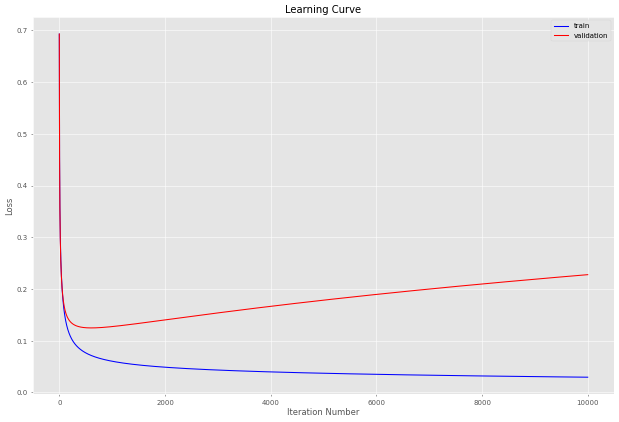

In [13]:
pipeline1["classifier"].plot_learning_curve()

### 【問題6 解答】
上図のような学習曲線が得られた。
約500回目のイテレーションまでは損失が急速に下がっているが、その先は学習データの損失は緩やかに下がり続ける一方で、検証データの損失は逆に上がり出すことがわかった。
このことから、今回作成したモデルはイテレーションを500回くらいに設定した場合に最も高い汎化性能が得られると言える。

## 【問題7】決定領域の可視化
決定領域を可視化してください。

### ●決定領域描画用の関数

In [21]:
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['0', '1']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。
    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

### ●データセットの準備（アヤメのデータセットの内、sepal_lengthとpetal_lengthの列のみを抽出）

In [22]:
np.set_printoptions(threshold=100)   #配列の表示数上限の設定
pd.set_option('display.max_rows', 10)    #DataFrameの行の表示数上限の設定
pd.set_option('display.max_columns', 5)   #DataFrameの列の表示数上限の設定

#上記で用意したアヤメのデータセットについて、説明変数をsepal lengthとpetal lengthの2つのみに絞る。
df_iris2 = df_iris.drop("sepal width (cm)", axis=1)
df_iris2 = df_iris2.drop("petal width (cm)", axis=1)

display(df_iris2)

X = np.array(df_iris2.iloc[:, :-1])
y = np.array(df_iris2.iloc[:, -1])

#データセットを学習用と検証用に分割
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, train_size = 0.75, random_state=0)

,sepal length (cm),petal length (cm),species
50,7.0,4.7,1
51,6.4,4.5,1
52,6.9,4.9,1
53,5.5,4.0,1
54,6.5,4.6,1
...,...,...,...
145,6.7,5.2,2
146,6.3,5.0,2
147,6.5,5.2,2
148,6.2,5.4,2


### ●【動作確認】ScratchLogisticRegressionクラスを用いたロジスティック回帰（イテレーション:10）

In [23]:
# 標準化処理とロジスティック回帰をパイプラインに組み込み
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),      #変換器
    ("classifier", ScratchLogisticRegression(num_iter=10, lr=0.2, no_bias=0, verbose=False, threshold=0.5, ramda=0)) #推定器
])

X = X_train2
Xt = X_test2
y = y_train2
yt = y_test2

# 学習・推定・評価
pipeline.fit(X, y)
y_predict = pipeline.predict(Xt)
y_predict_proba = pipeline.predict_proba(Xt)

print("y_true:")
print(yt)
print("y_predict:")
print(y_predict)
# print("y_predict_proba:")
# print(y_predict_proba)

# 推定器のスコアを計算し、スコアボードに記録
score_board2.calcurate_scores(yt, y_predict, y_predict_proba[:, -1], ["ScratchLogisticReg(iter:10, feature:2)"])

y_true:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 1 2 1]
y_predict:
[2 2 2 2 2 2 1 2 2 2 2 1 2 1 1 1 2 1 2 1 1 2 1 1 1]


###Confusion matrix（混同行列）###
[[ 9  4]
 [ 2 10]]


スコアボード2:


,"ScratchLogisticReg(iter:10, feature:2)","ScratchLogisticReg(iter:1000, feature:2)","ScratchLogisticReg(iter:10, feature:2)"
Accuacy,0.760000,0.920000,0.760000
Precision,0.818182,1.000000,0.818182
Recall,0.692308,0.846154,0.692308
F1,0.750000,0.916667,0.750000
ROC_AUC,0.907051,0.977564,0.907051


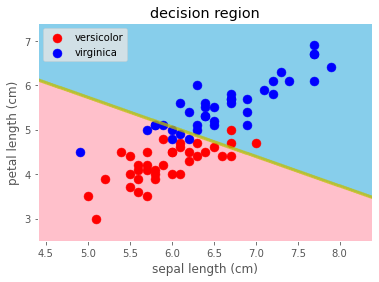

In [24]:
# 決定領域を描画
decision_region(X, y, model=pipeline, step=0.01, title='decision region', xlabel=df_iris2.columns[0], ylabel=df_iris2.columns[1], target_names=iris.target_names[1:])

### ●【動作確認】ScratchLogisticRegressionクラスを用いたロジスティック回帰（イテレーション:1000）

In [25]:
# 標準化処理とロジスティック回帰をパイプラインに組み込み
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),      #変換器
    ("classifier", ScratchLogisticRegression(num_iter=1000, lr=0.2, no_bias=0, verbose=False, threshold=0.5, ramda=0)) #推定器
])

X = X_train2
Xt = X_test2
y = y_train2
yt = y_test2

# 学習・推定・評価
pipeline.fit(X, y)
y_predict = pipeline.predict(Xt)
y_predict_proba = pipeline.predict_proba(Xt)

print("y_true:")
print(yt)
print("y_predict:")
print(y_predict)
# print("y_predict_proba:")
# print(y_predict_proba)

# 推定器のスコアを計算し、スコアボードに記録
score_board2.calcurate_scores(yt, y_predict, y_predict_proba[:, -1], ["ScratchLogisticReg(iter:1000, feature:2)"])

y_true:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 1 2 1]
y_predict:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]


###Confusion matrix（混同行列）###
[[11  2]
 [ 0 12]]


スコアボード2:


,"ScratchLogisticReg(iter:10, feature:2)","ScratchLogisticReg(iter:1000, feature:2)","ScratchLogisticReg(iter:10, feature:2)","ScratchLogisticReg(iter:1000, feature:2)"
Accuacy,0.760000,0.920000,0.760000,0.920000
Precision,0.818182,1.000000,0.818182,1.000000
Recall,0.692308,0.846154,0.692308,0.846154
F1,0.750000,0.916667,0.750000,0.916667
ROC_AUC,0.907051,0.977564,0.907051,0.977564


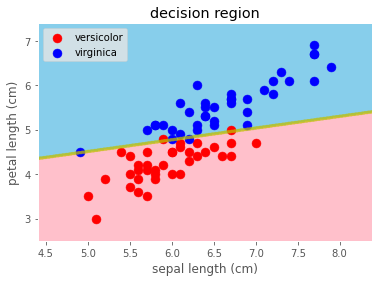

In [26]:
# 決定領域を描画
decision_region(X, y, model=pipeline, step=0.01, title='decision region', xlabel=df_iris2.columns[0], ylabel=df_iris2.columns[1], target_names=iris.target_names[1:])

### 【問題7 解答】
　本問題では、特徴量の数を4→2個に削減し、イテレーション数=10と1000の2通りに設定して学習・推定・決定領域のグラフ化を行った。<br>
　その結果、イテレーション数=10の場合は特徴量が4つの時に比べて推定精度が下がった。決定領域のグラフに関しても、実際の正解ラベルのデータ分布から少し外れた境界線が引かれてしまい、期待と異なるものとなった。<br>
　一方で、イテレーション数=1000の場合は10の場合に比べて推定精度が高く、決定領域のグラフも期待通りのものが得られた。